## Código para testar o modelo de YOLO

---

In [6]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import numpy as np
from paddleocr import PaddleOCR
import os
import re
import requests

### Identificação de placas de carros:

In [7]:
def classify_image(image_path):    
    model = YOLO('last.pt')  
    results = model(image_path)
    
    # Display results
    for result in results:
        img_rgb = cv2.cvtColor(result.plot(show=False), cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 10))
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.show()

def classify_and_crop(image_path):
    # Load model
    model = YOLO('last.pt')
    
    # Run inference
    results = model(image_path)
    
    # Read the original image
    original_image = cv2.imread(image_path)
    imgnames = []


    # Iterate over results
    for i, result in enumerate(results):
        boxes = result.boxes.xyxy.cpu().numpy()  # Get bounding boxes in (x1, y1, x2, y2) format

        for j, (x1, y1, x2, y2) in enumerate(boxes):
            # Convert coordinates to integers
            x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])

            # Crop the image
            cropped = original_image[y1:y2, x1:x2]

            # Convert BGR to RGB for displaying
            cropped_rgb = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
            # Save the cropped image
            output_filename = f'cropped_{i}_{j}.png'
            imgnames.append(output_filename)
            cv2.imwrite(output_filename, cropped)

            # Show the cropped region
            plt.figure(figsize=(4, 4))
            plt.imshow(cropped_rgb)
            plt.axis('off')
            plt.title(f'Cropped #{i}-{j}')
            plt.show()
    return imgnames            

### Lendo o texto das placas

In [8]:
def change_char_in_position(word, position):
    if position < len(word):
        if word[position].isdigit():
            digit = word[position]
            if digit == '8':
                word = word[:position] + 'B' + word[position+1:]
            elif digit == '1':
                word = word[:position] + 'I' + word[position+1:]
    return word

def detect_blue_strip(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return False

    height, width = image.shape[:2]
    top_strip = image[0:int(height * 0.15), 0:width]  # faixa de cima

    hsv = cv2.cvtColor(top_strip, cv2.COLOR_BGR2HSV)

    # Faixa de azul (com tolerância maior para placas borradas)
    lower_blue = np.array([90, 40, 40])
    upper_blue = np.array([140, 255, 255])
    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    blue_ratio = cv2.countNonZero(mask) / (top_strip.shape[0] * top_strip.shape[1])
    return blue_ratio > 0.03

def limpar_placa(texto):
    """Remove qualquer caractere que não seja letra ou número."""
    return re.sub(r'[^A-Z0-9]', '', texto.upper())

def correct_plate(word, is_new_plate):
    word = word.replace("-", "").replace(".", "").replace(" ", "")
    word = limpar_placa(word)

    if len(word) < 7:
        return None

    for pos in [0, 1, 2]:
        if word[pos].isdigit():
            word = change_char_in_position(word, pos)
    
    if is_new_plate and len(word) > 4 and word[4].isdigit():
        word = change_char_in_position(word, 4)

    # Verifica os dois formatos válidos
    if re.match(r'^[A-Z]{3}\d{4}$', word) or re.match(r'^[A-Z]{3}\d[A-Z]\d{2}$', word):
        return word

    return None

ocr = PaddleOCR(use_angle_cls=True, lang='en', show_log=False)

def extract_plate_from_image(image_path):
    is_new_plate = detect_blue_strip(image_path)
    result = ocr.ocr(image_path, cls=True)
    
    if not result or result[0] is None:
        print("No text detected.")
        return None    
    
    detected_words = []
    for line in result:
        for word_info in line:
            text = word_info[1][0].replace(" ", "")
            if text.lower() == "brasil":
                is_new_plate = True
            else:
                detected_words.append((text, word_info[1][1]))  # (text, confidence)
    
    print(f"Palavras detectadas: {detected_words}")
    print(f"É nova placa? {is_new_plate}")    
    
    # Tenta cada palavra isolada
    for word_tuple in detected_words:
        corrected = correct_plate(word_tuple[0], is_new_plate)
        if corrected:
            return corrected

    # Tenta pares de palavras combinadas
    for i in range(len(detected_words)):
        for j in range(i+1, len(detected_words)):
            combined = detected_words[i][0] + detected_words[j][0]
            corrected = correct_plate(combined, is_new_plate)
            if corrected:
                return corrected

    return None


### Testando com imagens reais

In [9]:
image_path = 'imgs/21.png'
imgs = classify_and_crop(image_path)


image 1/1 /home/louis/Documents/7/compvis/compvis-car/imgs/21.png: 384x640 (no detections), 820.0ms
Speed: 4.6ms preprocess, 820.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


In [10]:
plates = []
for img in imgs:
    print(f"Processing image: {img}")
    plate = extract_plate_from_image(img)
    print(f"Plate detected: {plate}")
    if plate:
        plates.append(plate)
    print('-'*20)


----


image 1/1 /home/louis/Documents/7/compvis/compvis-car/imgs/74.png: 384x640 2 License_Plates, 637.8ms
Speed: 4.6ms preprocess, 637.8ms inference, 12.4ms postprocess per image at shape (1, 3, 384, 640)


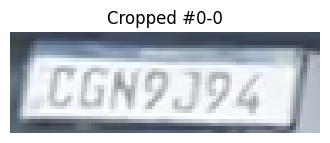

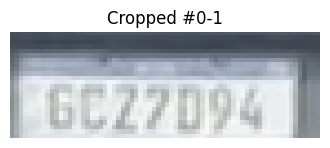

In [14]:
image_path = './imgs/74.png'
imgs = classify_and_crop(image_path)

In [15]:
plates = []
for img in imgs:
    print(f"Processing image: {img}")
    plate = extract_plate_from_image(img)
    print(f"Plate detected: {plate}")
    if plate:
        plates.append(plate)
    print('-'*20)


Processing image: cropped_0_0.png
Palavras detectadas: [('CGN9J94', 0.9399803280830383)]
É nova placa? True
Plate detected: CGN9J94
--------------------
Processing image: cropped_0_1.png
No text detected.
Plate detected: None
--------------------


In [ ]:
token = os.getenv('API_TOKEN', 'não-encontrado')
token

In [ ]:
api_url = 'https://wdapi2.com.br/consulta/{placa}/{token}'

placa = plates[1]
token = os.getenv('API_TOKEN', 'default_token_value')
response = requests.get(api_url.format(placa=placa, token=token))
if response.status_code == 200:
    data = response.json()
    print(f"API Response: {data}")

In [ ]:
def get_infos(data):
    info = {}
    marca = data['marca']
    modelo = data['modelo']
    ano = data['ano']
    cor = data['cor']

    info = {
        'marca': marca,
        'modelo': modelo,
        'ano': ano,
        'cor': cor
    }

    extra = data['extra']

    campos_interesse = ['municipio', 'nacionalidade', 'sub_segmento']
    for chave in campos_interesse:
        if chave in extra:
            info[chave] = extra[chave]
        else:
            info[chave] = None
            
    fipe = data['fipe']['dados']
    sum = 0
    i = 0
    for dados in fipe:
        valor = dados['texto_valor']
        valor = valor.replace("R$", "")
        valor = valor.replace(".", "")
        valor = valor.replace(",", ".")
        valor = float(valor)
        sum += valor
        i += 1
        
    media = sum / i
    info['fipe'] = media
    
    return info

info = get_infos(data)
print(info)
            